In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Read and preprocess data

Dataset contains information about various features related to the telcom company.We would like to predict which customers will churn based on this data.

In [2]:
data = pd.read_csv('data_raw.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [3]:
data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

Data consists of various parameters collected for period of four months from June to September. There is no specific indication which customer is going to churn. Therefore we specify the last month as the one in which customer will churn and in which we should see some large deviations in previously stable parameters. June and July will be considered the good months when we should not observe large deviations from the overall trend. August will be the "action" month when some parameters start to rapidly change.

Since the number of customers is large and we are only interested in retaining the most valuable ones (most of the revenue comes from them), we can filter them according to some parameters. The good choice could be a recharge rate. There are 2 types of recharge as you could see below. We only take into consideration the "good" months and calculated the average over these 2 months. Then we choose the customers with the average recharge rate larger then the 70th percentile. 

In [4]:
data['total_data_rech_6'] = data['total_rech_data_6'] * data['av_rech_amt_data_6']
data['total_data_rech_7'] = data['total_rech_data_7'] * data['av_rech_amt_data_7']

data['amt_data_6'] = data[['total_rech_amt_6', 'total_data_rech_6']].sum(axis=1)
data['amt_data_7'] = data[['total_rech_amt_7', 'total_data_rech_7']].sum(axis=1)

data['AVG_amt_data_6_7'] = data[['amt_data_6', 'amt_data_7']].mean(axis=1)

In [5]:
data['AVG_amt_data_6_7'].quantile(np.arange(0, 1, 0.1))

0.0       0.0
0.1      60.0
0.2     108.5
0.3     155.0
0.4     209.5
0.5     275.0
0.6     360.0
0.7     478.0
0.8     656.5
0.9    1028.0
Name: AVG_amt_data_6_7, dtype: float64

In [6]:
df = data.copy()
df = df[df['AVG_amt_data_6_7'] > df['AVG_amt_data_6_7'].quantile(0.7)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Columns: 231 entries, mobile_number to AVG_amt_data_6_7
dtypes: float64(184), int64(35), object(12)
memory usage: 53.0+ MB


To decide which customers are going to churn we can look at the 4 parameters indicating the total incoming and outgoing calls in the last month and also how much mobile data was used. We select the churners if either incoming or outgoing calls and 2g or 3g data usage was equal to 0. With this condition we can filter all the customers and create a new column which assigns **1** to churners and **0** otherwise.

In [7]:
df['churn_flag'] = np.where(((df['total_ic_mou_9'] == 0.0) | (df['total_og_mou_9'] == 0.0))
                            & ((df['vol_2g_mb_9'] == 0.0) | (df['vol_3g_mb_9'] == 0.0)), 1, 0)

Since we only needed last month info to select the churners, we can delete all columns related to this month. Our training should not be based on the month in which customer already churned. For this we can use regular expressions to identify columns with **'_9'** and **'sep'** pattern and drop them.

In [8]:
df.drop(df.filter(regex='_9|sep').columns, axis=1, inplace=True)

In [9]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Data columns (total 177 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   mobile_number             int64  
 1   circle_id                 int64  
 2   loc_og_t2o_mou            float64
 3   std_og_t2o_mou            float64
 4   loc_ic_t2o_mou            float64
 5   last_date_of_month_6      object 
 6   last_date_of_month_7      object 
 7   last_date_of_month_8      object 
 8   arpu_6                    float64
 9   arpu_7                    float64
 10  arpu_8                    float64
 11  onnet_mou_6               float64
 12  onnet_mou_7               float64
 13  onnet_mou_8               float64
 14  offnet_mou_6              float64
 15  offnet_mou_7              float64
 16  offnet_mou_8              float64
 17  roam_ic_mou_6             float64
 18  roam_ic_mou_7             float64
 19  roam_ic_mou_8             float64
 20  roam_og_mou_6             f

In the next step we can look fow the number of unique values for each feature. Here we can easily notice that some features have only single value. This means that we can drop these features as they do not give us any valuable information.

In [10]:
df.nunique()

mobile_number               29953
circle_id                       1
loc_og_t2o_mou                  1
std_og_t2o_mou                  1
loc_ic_t2o_mou                  1
last_date_of_month_6            1
last_date_of_month_7            1
last_date_of_month_8            1
arpu_6                      29029
arpu_7                      29040
arpu_8                      28035
onnet_mou_6                 16872
onnet_mou_7                 16973
onnet_mou_8                 15854
offnet_mou_6                21198
offnet_mou_7                21233
offnet_mou_8                20140
roam_ic_mou_6                4045
roam_ic_mou_7                3381
roam_ic_mou_8                3431
roam_og_mou_6                4742
roam_og_mou_7                3988
roam_og_mou_8                3996
loc_og_t2t_mou_6            10416
loc_og_t2t_mou_7            10388
loc_og_t2t_mou_8            10056
loc_og_t2m_mou_6            15607
loc_og_t2m_mou_7            15659
loc_og_t2m_mou_8            15118
loc_og_t2f_mou

In [11]:
df.drop(columns=df.columns[df.nunique()==1], axis=1, inplace=True)

Now we have to check how many missing values we have in all the columns. We can display it as the fraction of the entire dataset in percentages.

In [12]:
(df.isna().sum() * 100 / len(df)).sort_values(ascending=False)

date_of_last_rech_data_8    46.799987
total_rech_data_8           46.799987
night_pck_user_8            46.799987
arpu_2g_8                   46.799987
arpu_3g_8                   46.799987
fb_user_8                   46.799987
count_rech_2g_8             46.799987
max_rech_data_8             46.799987
av_rech_amt_data_8          46.799987
count_rech_3g_8             46.799987
max_rech_data_6             44.112443
date_of_last_rech_data_6    44.112443
count_rech_2g_6             44.112443
arpu_2g_6                   44.112443
av_rech_amt_data_6          44.112443
night_pck_user_6            44.112443
total_rech_data_6           44.112443
arpu_3g_6                   44.112443
count_rech_3g_6             44.112443
total_data_rech_6           44.112443
fb_user_6                   44.112443
arpu_3g_7                   43.117551
arpu_2g_7                   43.117551
count_rech_3g_7             43.117551
av_rech_amt_data_7          43.117551
total_data_rech_7           43.117551
max_rech_dat

It seems that most of the missing values comes from the data related features. Now we can check for the data related features in eg. last month for which eg. **arpu_3g_8** is missing. It is clear that these customers have not bought any data in that specific month so that we can safely replace all missing values here with 0. Same happens for month 6 and 7

In [13]:
df[df['arpu_3g_8'].isna()][['date_of_last_rech_data_8','total_rech_data_8','max_rech_data_8','count_rech_2g_8', 
                            'count_rech_3g_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_2g_8',
                            'night_pck_user_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8',
                            'fb_user_8']].head()

date_of_last_rech_data_8  total_rech_data_8  max_rech_data_8  \
7                       NaN                NaN              NaN   
21                      NaN                NaN              NaN   
38                      NaN                NaN              NaN   
41                      NaN                NaN              NaN   
48                      NaN                NaN              NaN   

    count_rech_2g_8  count_rech_3g_8  av_rech_amt_data_8  vol_2g_mb_8  \
7               NaN              NaN                 NaN          0.0   
21              NaN              NaN                 NaN          0.0   
38              NaN              NaN                 NaN          0.0   
41              NaN              NaN                 NaN          0.0   
48              NaN              NaN                 NaN          0.0   

    vol_3g_mb_8  arpu_2g_8  night_pck_user_8  monthly_2g_8  sachet_2g_8  \
7           0.0        NaN               NaN             0            0   
21          0.0        NaN               NaN             0            0   
38          0.0        NaN               NaN             0            0   
41          0.0        NaN               NaN             0            0   
48          0.0        NaN               NaN             0            0   

    monthly_3g_8  sachet_3g_8  fb_user_8  
7              0            0        NaN  
21             0            0        NaN  
38             0            0        NaN  
41             0            0        NaN  
48             0            0        NaN

In [14]:
df[df['arpu_3g_8'].isna()][['date_of_last_rech_data_8','total_rech_data_8','max_rech_data_8','count_rech_2g_8', 
                            'count_rech_3g_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_2g_8',
                            'night_pck_user_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8',
                            'fb_user_8']].nunique()

date_of_last_rech_data_8    0
total_rech_data_8           0
max_rech_data_8             0
count_rech_2g_8             0
count_rech_3g_8             0
av_rech_amt_data_8          0
vol_2g_mb_8                 1
vol_3g_mb_8                 1
arpu_2g_8                   0
night_pck_user_8            0
monthly_2g_8                1
sachet_2g_8                 1
monthly_3g_8                1
sachet_3g_8                 1
fb_user_8                   0
dtype: int64

In [15]:
df.fillna(0, inplace=True)

The next step is to check if we have any features of type **object** as we will have to convert them to numerical type for training.

In [16]:
df.dtypes

mobile_number                 int64
arpu_6                      float64
arpu_7                      float64
arpu_8                      float64
onnet_mou_6                 float64
onnet_mou_7                 float64
onnet_mou_8                 float64
offnet_mou_6                float64
offnet_mou_7                float64
offnet_mou_8                float64
roam_ic_mou_6               float64
roam_ic_mou_7               float64
roam_ic_mou_8               float64
roam_og_mou_6               float64
roam_og_mou_7               float64
roam_og_mou_8               float64
loc_og_t2t_mou_6            float64
loc_og_t2t_mou_7            float64
loc_og_t2t_mou_8            float64
loc_og_t2m_mou_6            float64
loc_og_t2m_mou_7            float64
loc_og_t2m_mou_8            float64
loc_og_t2f_mou_6            float64
loc_og_t2f_mou_7            float64
loc_og_t2f_mou_8            float64
loc_og_t2c_mou_6            float64
loc_og_t2c_mou_7            float64
loc_og_t2c_mou_8            

It looks like there are 6 object type features which are dates. First let's convert them to **datetime** format.

In [17]:
df['date_of_last_rech_6'] = pd.to_datetime(df['date_of_last_rech_6'])
df['date_of_last_rech_7'] = pd.to_datetime(df['date_of_last_rech_7'])
df['date_of_last_rech_8'] = pd.to_datetime(df['date_of_last_rech_8'])
df['date_of_last_rech_data_6'] = pd.to_datetime(df['date_of_last_rech_data_6'])
df['date_of_last_rech_data_7'] = pd.to_datetime(df['date_of_last_rech_data_7'])
df['date_of_last_rech_data_8'] = pd.to_datetime(df['date_of_last_rech_data_8'])

To get valuable information from raw dates of last recharge, we should extract the day number in the specific month to see if maybe certain days cause some issues.

In [18]:
df['date_of_last_rech_day_6'] = df['date_of_last_rech_6'].dt.day
df['date_of_last_rech_day_7'] = df['date_of_last_rech_7'].dt.day
df['date_of_last_rech_day_8'] = df['date_of_last_rech_8'].dt.day
df['date_of_last_rech_data_day_6'] = df['date_of_last_rech_data_6'].dt.day
df['date_of_last_rech_data_day_7'] = df['date_of_last_rech_data_7'].dt.day
df['date_of_last_rech_data_day_8'] = df['date_of_last_rech_data_8'].dt.day

Below we can see 20 top correlations between the target and features. They are relatively low.

<AxesSubplot:>

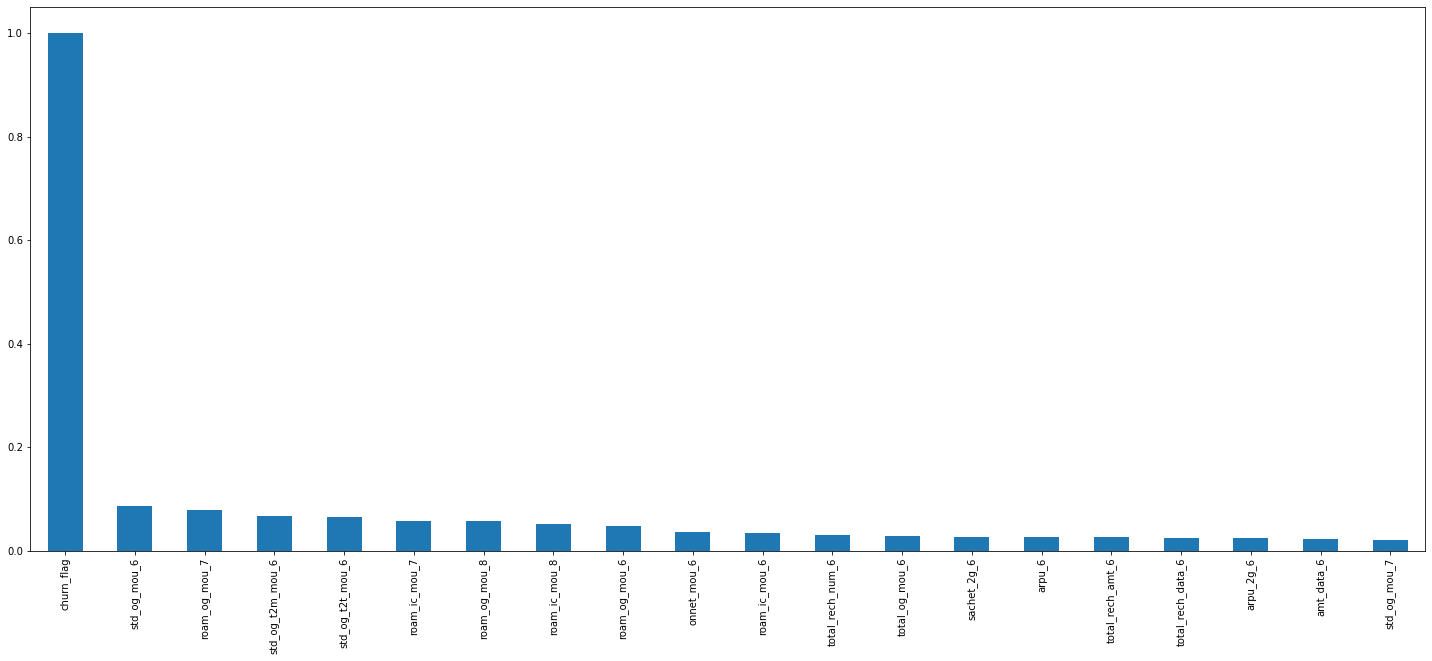

In [19]:
plt.figure(figsize=(25,10))
df.corr()['churn_flag'].sort_values(ascending=False)[:20].plot(kind ='bar')

We have lots of features and it is very likely that some of them won't be really helpful for the model to learn. Therefore it is good to check correlations between each of the feature with any other feature and derive some new insight for highly correlated features. Below we can see that correlation is very high for the same features with only vayring month. Let's derive a new feature which will tell us if the average from month 6 and 7 is larger or smaller then the value in month 8. This can be a good indication that something starts to happen in the **"action"** month.

In [20]:
df.corr().stack().reset_index().sort_values(by=0, ascending=False)

level_0                       level_1  \
0                     mobile_number                 mobile_number   
6930                   std_og_mou_8                  std_og_mou_8   
9900               loc_ic_t2m_mou_8              loc_ic_t2m_mou_8   
9735               loc_ic_t2m_mou_7              loc_ic_t2m_mou_7   
9570               loc_ic_t2m_mou_6              loc_ic_t2m_mou_6   
9405               loc_ic_t2t_mou_8              loc_ic_t2t_mou_8   
9240               loc_ic_t2t_mou_7              loc_ic_t2t_mou_7   
9075               loc_ic_t2t_mou_6              loc_ic_t2t_mou_6   
8910                 total_og_mou_8                total_og_mou_8   
8745                 total_og_mou_7                total_og_mou_7   
8580                 total_og_mou_6                total_og_mou_6   
8415                    og_others_8                   og_others_8   
8250                    og_others_7                   og_others_7   
8085                    og_others_6                   og_others_6   
7920                   spl_og_mou_8                  spl_og_mou_8   
7755                   spl_og_mou_7                  spl_og_mou_7   
7590                   spl_og_mou_6                  spl_og_mou_6   
7425                   isd_og_mou_8                  isd_og_mou_8   
7260                   isd_og_mou_7                  isd_og_mou_7   
10065              loc_ic_t2f_mou_6              loc_ic_t2f_mou_6   
10230              loc_ic_t2f_mou_7              loc_ic_t2f_mou_7   
10395              loc_ic_t2f_mou_8              loc_ic_t2f_mou_8   
12045              std_ic_t2f_mou_6              std_ic_t2f_mou_6   
13200                total_ic_mou_7                total_ic_mou_7   
13035                total_ic_mou_6                total_ic_mou_6   
12870                  std_ic_mou_8                  std_ic_mou_8   
12705                  std_ic_mou_7                  std_ic_mou_7   
12540                  std_ic_mou_6                  std_ic_mou_6   
12375              std_ic_t2f_mou_8              std_ic_t2f_mou_8   
12210              std_ic_t2f_mou_7              std_ic_t2f_mou_7   
11880              std_ic_t2m_mou_8              std_ic_t2m_mou_8   
10560                  loc_ic_mou_6                  loc_ic_mou_6   
11715              std_ic_t2m_mou_7              std_ic_t2m_mou_7   
11550              std_ic_t2m_mou_6              std_ic_t2m_mou_6   
11385              std_ic_t2t_mou_8              std_ic_t2t_mou_8   
11220              std_ic_t2t_mou_7              std_ic_t2t_mou_7   
11055              std_ic_t2t_mou_6              std_ic_t2t_mou_6   
10890                  loc_ic_mou_8                  loc_ic_mou_8   
10725                  loc_ic_mou_7                  loc_ic_mou_7   
7095                   isd_og_mou_6                  isd_og_mou_6   
6765                   std_og_mou_7                  std_og_mou_7   
13530                  spl_ic_mou_6                  spl_ic_mou_6   
6600                   std_og_mou_6                  std_og_mou_6   
3135               loc_og_t2m_mou_6              loc_og_t2m_mou_6   
2970               loc_og_t2t_mou_8              loc_og_t2t_mou_8   
2805               loc_og_t2t_mou_7              loc_og_t2t_mou_7   
2640               loc_og_t2t_mou_6              loc_og_t2t_mou_6   
2475                  roam_og_mou_8                 roam_og_mou_8   
2310                  roam_og_mou_7                 roam_og_mou_7   
2145                  roam_og_mou_6                 roam_og_mou_6   
1980                  roam_ic_mou_8                 roam_ic_mou_8   
1815                  roam_ic_mou_7                 roam_ic_mou_7   
1650                  roam_ic_mou_6                 roam_ic_mou_6   
1485                   offnet_mou_8                  offnet_mou_8   
1320                   offnet_mou_7                  offnet_mou_7   
1155                   offnet_mou_6                  offnet_mou_6   
990                     onnet_mou_8                   onnet_mou_8   
825                     on

In [21]:
df['AVG_arpu_6_7'] = df[['arpu_6','arpu_7']].mean(axis=1)
df['is_arpu_flag'] = np.where((df['arpu_8'] > df['AVG_arpu_6_7']), 0, 1)

df['AVG_onnet_mou_6_7'] = df[['onnet_mou_6','onnet_mou_7']].mean(axis=1)
df['is_onnet_mou_flag'] = np.where((df['onnet_mou_8'] > df['AVG_onnet_mou_6_7']), 0, 1)

df['AVG_offnet_mou_6_7'] = df[['offnet_mou_6','offnet_mou_7']].mean(axis=1)
df['is_offnet_mou_flag'] = np.where((df['offnet_mou_8'] > df['AVG_offnet_mou_6_7']), 0, 1)

df['AVG_roam_ic_mou_6_7'] = df[['roam_ic_mou_6','roam_ic_mou_7']].mean(axis=1)
df['is_roam_ic_mou_flag'] = np.where((df['roam_ic_mou_8'] > df['AVG_roam_ic_mou_6_7']), 0, 1)

df['AVG_roam_og_mou_6_7'] = df[['roam_og_mou_6','roam_og_mou_7']].mean(axis=1)
df['is_roam_og_mou_flag'] = np.where((df['roam_og_mou_8'] > df['AVG_roam_og_mou_6_7']), 0, 1)

df['AVG_loc_og_t2t_mou_6_7'] = df[['loc_og_t2t_mou_6','loc_og_t2t_mou_7']].mean(axis=1)
df['is_loc_og_t2t_mou_flag'] = np.where((df['loc_og_t2t_mou_8'] > df['AVG_loc_og_t2t_mou_6_7']), 0, 1)

df['AVG_loc_og_t2m_mou_6_7'] = df[['loc_og_t2m_mou_6','loc_og_t2m_mou_7']].mean(axis=1)
df['is_loc_og_t2m_mou_flag'] = np.where((df['loc_og_t2m_mou_8'] > df['AVG_loc_og_t2m_mou_6_7']), 0, 1)

df['AVG_loc_og_t2f_mou_6_7'] = df[['loc_og_t2f_mou_6','loc_og_t2f_mou_7']].mean(axis=1)
df['is_loc_og_t2f_mou_flag'] = np.where((df['loc_og_t2f_mou_8'] > df['AVG_loc_og_t2f_mou_6_7']), 0, 1)

df['AVG_loc_og_t2c_mou_6_7'] = df[['loc_og_t2c_mou_6','loc_og_t2c_mou_7']].mean(axis=1)
df['is_loc_og_t2c_mou_flag'] = np.where((df['loc_og_t2c_mou_8'] > df['AVG_loc_og_t2c_mou_6_7']), 0, 1)

df['AVG_std_og_t2t_mou_6_7'] = df[['std_og_t2t_mou_6','std_og_t2t_mou_7']].mean(axis=1)
df['is_std_og_t2t_mou_flag'] = np.where((df['std_og_t2t_mou_8'] > df['AVG_std_og_t2t_mou_6_7']), 0, 1)

df['AVG_std_og_t2m_mou_6_7'] = df[['std_og_t2m_mou_6','std_og_t2m_mou_7']].mean(axis=1)
df['is_std_og_t2m_mou_flag'] = np.where((df['std_og_t2m_mou_8'] > df['AVG_std_og_t2m_mou_6_7']), 0, 1)

df['AVG_std_og_t2f_mou_6_7'] = df[['std_og_t2f_mou_6','std_og_t2f_mou_7']].mean(axis=1)
df['is_std_og_t2f_mou_flag'] = np.where((df['std_og_t2f_mou_8'] > df['AVG_std_og_t2f_mou_6_7']), 0, 1)

df['AVG_isd_og_mou_6_7'] = df[['isd_og_mou_6','isd_og_mou_7']].mean(axis=1)
df['is_isd_og_mou_flag'] = np.where((df['isd_og_mou_8'] > df['AVG_isd_og_mou_6_7']), 0, 1)

df['AVG_spl_og_mou_6_7'] = df[['spl_og_mou_6','spl_og_mou_7']].mean(axis=1)
df['is_spl_og_mou_flag'] = np.where((df['spl_og_mou_8'] > df['AVG_spl_og_mou_6_7']), 0, 1)

df['AVG_og_others_6_7'] = df[['og_others_6','og_others_7']].mean(axis=1)
df['is_og_others_flag'] = np.where((df['og_others_8'] > df['AVG_og_others_6_7']), 0, 1)


df['AVG_loc_ic_t2t_mou_6_7'] = df[['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7']].mean(axis=1)
df['is_loc_ic_t2t_mou_flag'] = np.where((df['loc_ic_t2t_mou_8'] > df['AVG_loc_ic_t2t_mou_6_7']), 0, 1)

df['AVG_loc_ic_t2m_mou_6_7'] = df[['loc_ic_t2m_mou_6','loc_ic_t2m_mou_7']].mean(axis=1)
df['is_loc_ic_t2m_mou_flag'] = np.where((df['loc_ic_t2m_mou_8'] > df['AVG_loc_ic_t2m_mou_6_7']), 0, 1)

df['AVG_loc_ic_t2f_mou_6_7'] = df[['loc_ic_t2f_mou_6','loc_ic_t2f_mou_7']].mean(axis=1)
df['is_loc_ic_t2f_mou_flag'] = np.where((df['loc_ic_t2f_mou_8'] > df['AVG_loc_ic_t2f_mou_6_7']), 0, 1)

df['AVG_std_ic_t2t_mou_6_7'] = df[['std_ic_t2t_mou_6','std_ic_t2t_mou_7']].mean(axis=1)
df['is_std_ic_t2t_mou_flag'] = np.where((df['std_ic_t2t_mou_8'] > df['AVG_std_ic_t2t_mou_6_7']), 0, 1)

df['AVG_std_ic_t2m_mou_6_7'] = df[['std_ic_t2m_mou_6','std_ic_t2m_mou_7']].mean(axis=1)
df['is_std_ic_t2m_mou_flag'] = np.where((df['std_ic_t2m_mou_8'] > df['AVG_std_ic_t2m_mou_6_7']), 0, 1)

df['AVG_std_ic_t2f_mou_6_7'] = df[['std_ic_t2f_mou_6','std_ic_t2f_mou_7']].mean(axis=1)
df['is_std_ic_t2f_mou_flag'] = np.where((df['std_ic_t2f_mou_8'] > df['AVG_std_ic_t2f_mou_6_7']), 0, 1)

df['AVG_spl_ic_mou_6_7'] = df[['spl_ic_mou_6','spl_ic_mou_7']].mean(axis=1)
df['is_spl_ic_mou_flag'] = np.where((df['spl_ic_mou_8'] > df['AVG_spl_ic_mou_6_7']), 0, 1)

df['AVG_isd_ic_mou_6_7'] = df[['isd_ic_mou_6','isd_ic_mou_7']].mean(axis=1)
df['is_isd_ic_mou_flag'] = np.where((df['isd_ic_mou_8'] > df['AVG_isd_ic_mou_6_7']), 0, 1)

df['AVG_ic_others_6_7'] = df[['ic_others_6','ic_others_7']].mean(axis=1)
df['is_ic_others_flag'] = np.where((df['ic_others_8'] > df['AVG_ic_others_6_7']), 0, 1)

df['AVG_total_rech_amt_6_7'] = df[['total_rech_amt_6','total_rech_amt_7']].mean(axis=1)
df['is_total_rech_amt_flag'] = np.where((df['total_rech_amt_8'] > df['AVG_total_rech_amt_6_7']), 0, 1)

df['AVG_vol_2g_mb_6_7'] = df[['vol_2g_mb_6','vol_2g_mb_7']].mean(axis=1)
df['is_vol_2g_mb_flag'] = np.where((df['vol_2g_mb_8'] > df['AVG_vol_2g_mb_6_7']), 0, 1)

df['AVG_vol_3g_mb_6_7'] = df[['vol_3g_mb_6','vol_3g_mb_7']].mean(axis=1)
df['is_vol_3g_mb_flag'] = np.where((df['vol_3g_mb_8'] > df['AVG_vol_3g_mb_6_7']), 0, 1)

df['AVG_arpu_3g_6_7'] = df[['arpu_3g_6','arpu_3g_7']].mean(axis=1)
df['is_arpu_3g_flag'] = np.where((df['arpu_3g_8'] > df['AVG_arpu_3g_6_7']), 0, 1)

df['AVG_arpu_2g_6_7'] = df[['arpu_2g_6','arpu_2g_7']].mean(axis=1)
df['is_arpu_2g_flag'] = np.where((df['arpu_2g_8'] > df['AVG_arpu_2g_6_7']), 0, 1)

df['AVG_vbc_3g_6_7'] = df[['jun_vbc_3g','jul_vbc_3g']].mean(axis=1)
df['is_vbc_3g_flag'] = np.where((df['aug_vbc_3g'] > df['AVG_vbc_3g_6_7']), 0, 1)

df['AVG_loc_og_mou_6_7'] = df[['loc_og_mou_6','loc_og_mou_7']].mean(axis=1)
df['is_loc_og_mou_flag'] = np.where((df['loc_og_mou_8'] > df['AVG_loc_og_mou_6_7']), 0, 1)

df['AVG_std_og_mou_6_7'] = df[['std_og_mou_6','std_og_mou_7']].mean(axis=1)
df['is_std_og_mou_flag'] = np.where((df['std_og_mou_8'] > df['AVG_std_og_mou_6_7']), 0, 1)

df['AVG_total_og_mou_6_7'] = df[['total_og_mou_6','total_og_mou_7']].mean(axis=1)
df['is_total_og_mou_flag'] = np.where((df['total_og_mou_8'] > df['AVG_total_og_mou_6_7']), 0, 1)

df['AVG_loc_ic_mou_6_7'] = df[['loc_ic_mou_6','loc_ic_mou_7']].mean(axis=1)
df['is_loc_ic_mou_flag'] = np.where((df['loc_ic_mou_8'] > df['AVG_loc_ic_mou_6_7']), 0, 1)

df['AVG_std_ic_mou_6_7'] = df[['std_ic_mou_6','std_ic_mou_7']].mean(axis=1)
df['is_std_ic_mou_flag'] = np.where((df['std_ic_mou_8'] > df['AVG_std_ic_mou_6_7']), 0, 1)

df['AVG_total_ic_mou_6_7'] = df[['total_ic_mou_6','total_ic_mou_7']].mean(axis=1)
df['is_total_ic_mou_flag'] = np.where((df['total_ic_mou_8'] > df['AVG_total_ic_mou_6_7']), 0, 1)

df['AVG_night_pck_user_6_7'] = df[['night_pck_user_6','night_pck_user_7']].mean(axis=1)
df['is_night_pck_user_flag'] = np.where((df['night_pck_user_8'] > df['AVG_night_pck_user_6_7']), 0, 1)

df['AVG_monthly_2g_6_7'] = df[['monthly_2g_6','monthly_2g_7']].mean(axis=1)
df['is_monthly_2g_flag'] = np.where((df['monthly_2g_8'] > df['AVG_monthly_2g_6_7']), 0, 1)

df['AVG_sachet_2g_6_7'] = df[['sachet_2g_6','sachet_2g_7']].mean(axis=1)
df['is_sachet_2g_flag'] = np.where((df['sachet_2g_8'] > df['AVG_sachet_2g_6_7']), 0, 1)

df['AVG_monthly_3g_6_7'] = df[['monthly_3g_6','monthly_3g_7']].mean(axis=1)
df['is_monthly_3g_flag'] = np.where((df['monthly_3g_8'] > df['AVG_monthly_3g_6_7']), 0, 1)

df['AVG_sachet_3g_6_7'] = df[['sachet_3g_6','sachet_3g_7']].mean(axis=1)
df['is_sachet_3g_flag'] = np.where((df['sachet_3g_8'] > df['AVG_sachet_3g_6_7']), 0, 1)

df['AVG_fb_user_6_7'] = df[['fb_user_6','fb_user_7']].mean(axis=1)
df['is_fb_user_flag'] = np.where((df['fb_user_8'] > df['AVG_fb_user_6_7']), 0, 1)

For the other features we can calculate month on month change to examine if there is any indication about large deviations and rapid changes.

In [22]:
df['loc_og_t2t_mou_7diff6'] = df['loc_og_t2t_mou_7'] - df['loc_og_t2t_mou_6']
df['loc_og_t2m_mou_7diff6'] = df['loc_og_t2m_mou_7'] - df['loc_og_t2m_mou_6']
df['loc_og_t2f_mou_7diff6'] = df['loc_og_t2f_mou_7'] - df['loc_og_t2f_mou_6']
df['loc_og_t2c_mou_7diff6'] = df['loc_og_t2c_mou_7'] - df['loc_og_t2c_mou_6']
df['loc_og_mou_7diff6'] = df['loc_og_mou_7'] - df['loc_og_mou_6']
df['std_og_t2t_mou_7diff6'] = df['std_og_t2t_mou_7'] - df['std_og_t2t_mou_6']
df['std_og_t2m_mou_7diff6'] = df['std_og_t2m_mou_7'] - df['std_og_t2m_mou_6']
df['std_og_t2f_mou_7diff6'] = df['std_og_t2f_mou_7'] - df['std_og_t2f_mou_6']
df['std_og_mou_7diff6'] = df['std_og_mou_7'] - df['std_og_mou_6']
df['loc_og_mou_7diff6'] = df['loc_og_mou_7'] - df['loc_og_mou_6']
df['std_og_mou_7diff6'] = df['std_og_mou_7'] - df['std_og_mou_6']
df['isd_og_mou_7diff6'] = df['isd_og_mou_7'] - df['isd_og_mou_6']
df['spl_og_mou_7diff6'] = df['spl_og_mou_7'] - df['spl_og_mou_6']
df['og_others_7diff6'] = df['og_others_7'] - df['og_others_6']
df['total_og_mou_7diff6'] = df['total_og_mou_7'] - df['total_og_mou_6']

df['loc_og_t2t_mou_8diff7'] = df['loc_og_t2t_mou_8'] - df['loc_og_t2t_mou_7']
df['loc_og_t2m_mou_8diff7'] = df['loc_og_t2m_mou_8'] - df['loc_og_t2m_mou_7']
df['loc_og_t2f_mou_8diff7'] = df['loc_og_t2f_mou_8'] - df['loc_og_t2f_mou_7']
df['loc_og_t2c_mou_8diff7'] = df['loc_og_t2c_mou_8'] - df['loc_og_t2c_mou_7']
df['loc_og_mou_8diff7'] = df['loc_og_mou_8'] - df['loc_og_mou_7']
df['std_og_t2t_mou_8diff7'] = df['std_og_t2t_mou_8'] - df['std_og_t2t_mou_7']
df['std_og_t2m_mou_8diff7'] = df['std_og_t2m_mou_8'] - df['std_og_t2m_mou_7']
df['std_og_t2f_mou_8diff7'] = df['std_og_t2f_mou_8'] - df['std_og_t2f_mou_7']
df['std_og_mou_8diff7'] = df['std_og_mou_8'] - df['std_og_mou_7']
df['loc_og_mou_8diff7'] = df['loc_og_mou_8'] - df['loc_og_mou_7']
df['std_og_mou_8diff7'] = df['std_og_mou_8'] - df['std_og_mou_7']
df['isd_og_mou_8diff7'] = df['isd_og_mou_8'] - df['isd_og_mou_7']
df['spl_og_mou_8diff7'] = df['spl_og_mou_8'] - df['spl_og_mou_7']
df['og_others_8diff7'] = df['og_others_8'] - df['og_others_7']
df['total_og_mou_8diff7'] = df['total_og_mou_8'] - df['total_og_mou_7']

df['loc_ic_t2t_mou_7diff6'] = df['loc_ic_t2t_mou_7'] - df['loc_ic_t2t_mou_6']
df['loc_ic_t2m_mou_7diff6'] = df['loc_ic_t2m_mou_7'] - df['loc_ic_t2m_mou_6']
df['loc_ic_t2f_mou_7diff6'] = df['loc_ic_t2f_mou_7'] - df['loc_ic_t2f_mou_6']
df['loc_ic_mou_7diff6'] = df['loc_ic_mou_7'] - df['loc_ic_mou_6']
df['std_ic_t2t_mou_7diff6'] = df['std_ic_t2t_mou_7'] - df['std_ic_t2t_mou_6']
df['std_ic_t2m_mou_7diff6'] = df['std_ic_t2m_mou_7'] - df['std_ic_t2m_mou_6']
df['std_ic_t2f_mou_7diff6'] = df['std_ic_t2f_mou_7'] - df['std_ic_t2f_mou_6']
df['std_ic_mou_7diff6'] = df['std_ic_mou_7'] - df['std_ic_mou_6']
df['loc_ic_mou_7diff6'] = df['loc_ic_mou_7'] - df['loc_ic_mou_6']
df['std_ic_mou_7diff6'] = df['std_ic_mou_7'] - df['std_ic_mou_6']
df['spl_ic_mou_7diff6'] = df['spl_ic_mou_7'] - df['spl_ic_mou_6']
df['isd_ic_mou_7diff6'] = df['isd_ic_mou_7'] - df['isd_ic_mou_6']
df['ic_others_7diff6'] = df['ic_others_7'] - df['ic_others_6']
df['total_ic_mou_7diff6'] = df['total_ic_mou_7'] - df['total_ic_mou_6']

df['loc_ic_t2t_mou_8diff7'] = df['loc_ic_t2t_mou_8'] - df['loc_ic_t2t_mou_7']
df['loc_ic_t2m_mou_8diff7'] = df['loc_ic_t2m_mou_8'] - df['loc_ic_t2m_mou_7']
df['loc_ic_t2f_mou_8diff7'] = df['loc_ic_t2f_mou_8'] - df['loc_ic_t2f_mou_7']
df['loc_ic_mou_8diff7'] = df['loc_ic_mou_8'] - df['loc_ic_mou_7']
df['std_ic_t2t_mou_8diff7'] = df['std_ic_t2t_mou_8'] - df['std_ic_t2t_mou_7']
df['std_ic_t2m_mou_8diff7'] = df['std_ic_t2m_mou_8'] - df['std_ic_t2m_mou_7']
df['std_ic_t2f_mou_8diff7'] = df['std_ic_t2f_mou_8'] - df['std_ic_t2f_mou_7']
df['std_ic_mou_8diff7'] = df['std_ic_mou_8'] - df['std_ic_mou_7']
df['loc_ic_mou_8diff7'] = df['loc_ic_mou_8'] - df['loc_ic_mou_7']
df['std_ic_mou_8diff7'] = df['std_ic_mou_8'] - df['std_ic_mou_7']
df['spl_ic_mou_8diff7'] = df['spl_ic_mou_8'] - df['spl_ic_mou_7']
df['isd_ic_mou_8diff7'] = df['isd_ic_mou_8'] - df['isd_ic_mou_7']
df['ic_others_8diff7'] = df['ic_others_8'] - df['ic_others_7']
df['total_ic_mou_8diff7'] = df['total_ic_mou_8'] - df['total_ic_mou_7']

df['onnet_mou_7diff6'] = df['onnet_mou_7'] - df['onnet_mou_6']
df['onnet_mou_8diff7'] = df['onnet_mou_8'] - df['onnet_mou_7']

df['offnet_mou_7diff6'] = df['offnet_mou_7'] - df['offnet_mou_6']
df['offnet_mou_8diff7'] = df['offnet_mou_8'] - df['offnet_mou_7']

df['roam_ic_mou_7diff6'] = df['roam_ic_mou_7'] - df['roam_ic_mou_6']
df['roam_ic_mou_8diff7'] = df['roam_ic_mou_8'] - df['roam_ic_mou_7']

df['roam_og_mou_7diff6'] = df['roam_og_mou_7'] - df['roam_og_mou_6']
df['roam_og_mou_8diff7'] = df['roam_og_mou_8'] - df['roam_og_mou_7']

df['total_rech_amt_7diff6'] = df['total_rech_amt_7'] - df['total_rech_amt_6']
df['total_rech_amt_8diff7'] = df['total_rech_amt_8'] - df['total_rech_amt_7']

df['date_of_last_rech_7diff6'] = (df['date_of_last_rech_7'] - df['date_of_last_rech_6']).dt.days
df['date_of_last_rech_8diff7'] = (df['date_of_last_rech_8'] - df['date_of_last_rech_7']).dt.days

df['date_of_last_rech_data_7diff6'] = (df['date_of_last_rech_data_7'] - df['date_of_last_rech_data_6']).dt.days
df['date_of_last_rech_data_8diff7'] = (df['date_of_last_rech_data_8'] - df['date_of_last_rech_data_7']).dt.days

df['vol_2g_mb_7diff6'] = df['vol_2g_mb_7'] - df['vol_2g_mb_6']
df['vol_2g_mb_8diff7'] = df['vol_2g_mb_8'] - df['vol_2g_mb_7']

df['vol_3g_mb_7diff6'] = df['vol_3g_mb_7'] - df['vol_3g_mb_6']
df['vol_3g_mb_8diff7'] = df['vol_3g_mb_8'] - df['vol_3g_mb_7']

df['vbc_3g_7diff6'] = df['jul_vbc_3g'] - df['jun_vbc_3g']
df['vbc_3g_8diff7'] = df['aug_vbc_3g'] - df['jul_vbc_3g']

After deriving so many new features we should now drop the ones that won't be useful anymore. Let's first drop the **datetime** columns and **mobile_number**.

In [23]:
df.drop(list(df.select_dtypes(include=['datetime64']).columns), axis=1, inplace=True)
df.drop('mobile_number', axis=1 , inplace=True)

We have also derived averaged features for month 6 and 7 so we can drop raw values for single months.

In [24]:
df.drop(['arpu_6','arpu_7','onnet_mou_6','onnet_mou_7','offnet_mou_6','offnet_mou_7',
         'roam_ic_mou_6','roam_ic_mou_7','roam_og_mou_6','roam_og_mou_7',
         'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2m_mou_6','loc_og_t2m_mou_7',
         'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2c_mou_6','loc_og_t2c_mou_7',
         'std_og_t2t_mou_6','std_og_t2t_mou_7', 'std_og_t2m_mou_6','std_og_t2m_mou_7',
         'std_og_t2f_mou_6','std_og_t2f_mou_7','isd_og_mou_6','isd_og_mou_7',
         'spl_og_mou_6','spl_og_mou_7', 'og_others_6','og_others_7',
         'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7',
         'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7', 'std_ic_t2t_mou_6','std_ic_t2t_mou_7',
         'std_ic_t2m_mou_6','std_ic_t2m_mou_7', 'std_ic_t2f_mou_6','std_ic_t2f_mou_7',
         'spl_ic_mou_6','spl_ic_mou_7', 'isd_ic_mou_6','isd_ic_mou_7',
         'ic_others_6','ic_others_7', 'total_rech_amt_6','total_rech_amt_7',
         'vol_2g_mb_6','vol_2g_mb_7', 'vol_3g_mb_6','vol_3g_mb_7',
         'arpu_3g_6','arpu_3g_7', 'arpu_2g_6','arpu_2g_7',
         'jun_vbc_3g','jul_vbc_3g', 'loc_og_mou_6', 'loc_og_mou_7','std_og_mou_6', 'std_og_mou_7',
          'total_og_mou_6', 'total_og_mou_7','loc_ic_mou_6', 'loc_ic_mou_7',
          'std_ic_mou_6', 'std_ic_mou_7','total_ic_mou_6', 'total_ic_mou_7',
          'total_rech_num_6', 'total_rech_num_7','night_pck_user_6', 'night_pck_user_7',
          'monthly_2g_6', 'monthly_2g_7','sachet_2g_6', 'sachet_2g_7',
          'monthly_3g_6', 'monthly_3g_7','sachet_3g_6', 'sachet_3g_7','fb_user_6', 'fb_user_7'
        ], axis=1, inplace=True)

We have dropped a good amount of features but probably there are still some of them with very high correlations between each other. In this case we don't need all of them. For this purpose we can calculate the correlation matrix and take only absolute values from it. Then filter the upper part above the diagonal as we don't want duplicated values and create a list of columns to drop for which the correlation is higher then some specified threshold.

In [25]:
correlation_matrix = df.corr().abs()
correlation_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

In [26]:
to_drop = [column for column in correlation_matrix.columns if any(correlation_matrix[column] > 0.85)]

In [27]:
df.drop(columns=to_drop, axis=1, inplace=True)

In [28]:
df.shape

(29953, 202)

Finally we have 202 features. Let's look at the correlations between the top 20 features and our target.

<AxesSubplot:>

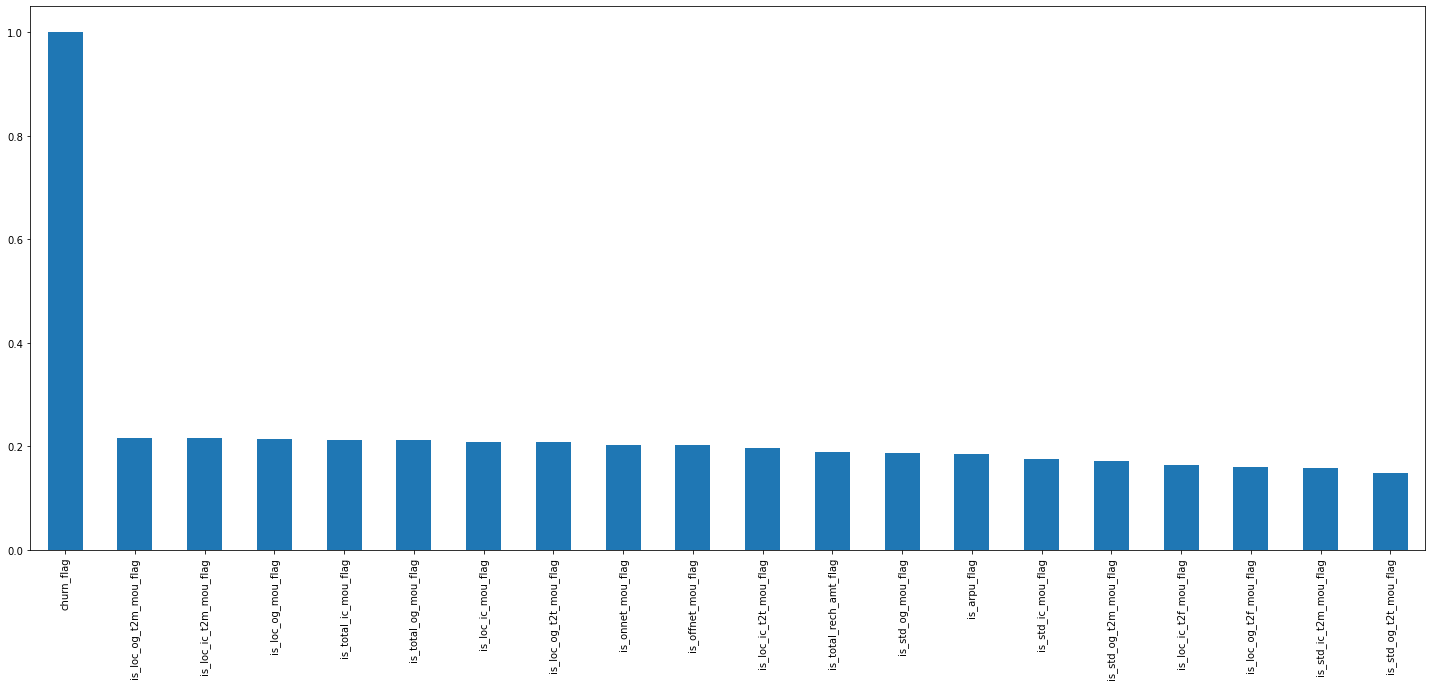

In [29]:
plt.figure(figsize=(25,10))
df.corr()['churn_flag'].sort_values(ascending=False)[:20].plot(kind ='bar')

It looks like our new derived features have higher correlations then the raw ones shown on the same plot before. We can now save the preprocessed data and start building our model.

In [30]:
df.to_csv('data_preprocessed.csv')